In [1]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error as mse
import warnings
from math import *
from scipy.stats import jarque_bera
from scipy.stats import normaltest
warnings.filterwarnings('ignore')

In [2]:
# Download the stock price data
stocks = 'AAPL'
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2023, 3, 30)
df = yf.download(stocks, start=start, end = end, interval='1d')

[*********************100%***********************]  1 of 1 completed


In [3]:
# Checking the data
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.565695,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.873642,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.875891,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.210686,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.140911,237458000


In [4]:
# Explanatory data analysis
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2074.000000,2074.000000,2074.000000,2074.000000,2074.000000,2.074000e+03
mean,75.119906,75.990459,74.292357,75.178168,73.472919,1.299627e+08
std,49.810314,50.482314,49.172684,49.855927,50.357628,6.776708e+07
min,22.500000,22.917500,22.367500,22.584999,20.883028,3.519590e+07
25%,32.690001,32.996249,32.474998,32.651875,29.865807,8.446092e+07
50%,49.725000,50.112499,49.332500,49.783749,48.221869,1.107118e+08
75%,127.809999,128.826248,126.115002,127.339998,126.088299,1.544310e+08
max,182.630005,182.940002,179.119995,182.009995,180.683884,6.488252e+08


In [5]:
# Calculate the returns of the price
df['return'] = df['Adj Close'].apply(lambda x: log(x)) - df['Adj Close'].shift(1).apply(lambda x: log(x))
df['return'] = df['return']*100

In [6]:
# Drop the null values and checking the dataframe
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,return
Date,,,,,,,
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.873642,257142000,-2.857595
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.875891,263188400,0.009419
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.210686,160423600,1.392490
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.140911,237458000,3.770235
2015-01-09,28.167500,28.312500,27.552500,28.002501,25.167875,214798000,0.107195


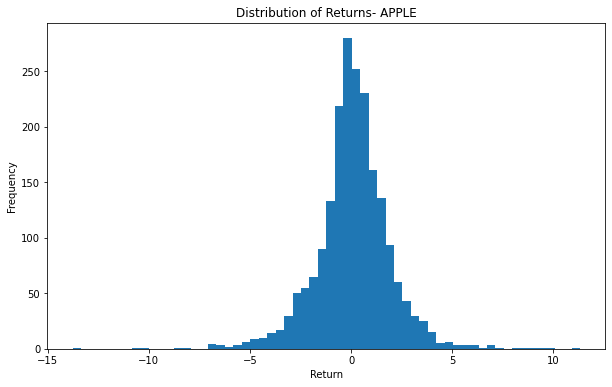

In [7]:
# Plotting the returns
plt.figure(figsize=(10, 6))
plt.hist(df['return'], bins=60)
plt.title('Distribution of Returns- APPLE')
plt.ylabel('Frequency')
plt.xlabel('Return');

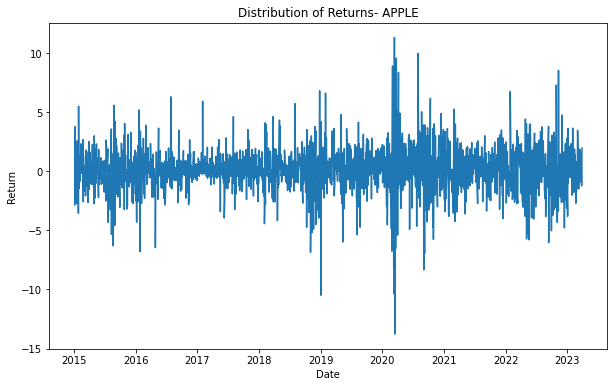

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(df['return'])
plt.title('Distribution of Returns- APPLE')
plt.ylabel('Return')
plt.xlabel('Date');

In [9]:
# Testing the normal distribution of the returns
skewness = np.mean(df['return'] - np.mean(df['return'])) / np.std(df['return'])
kurtosis = np.mean((df['return'] - np.mean(df['return'])) ** 4) / np.mean((df['return'] - np.mean(df['return'])) ** 2) ** 2 - 3
jb_test = jarque_bera(df['return'])
p_value = jb_test[1]
norm_test = normaltest(df['return'])
p_value = norm_test[1]
print('Jarque-Bera test p-value: ', jb_test[1])
print('Normality test p-value: ', norm_test[1])

Jarque-Bera test p-value:  0.0
Normality test p-value:  8.354877182995006e-57


In [10]:
# Calculating the realized volatility and dropping NA values and unnecessary columns
df['realized_vol'] = df['return'].rolling(5).std()*sqrt(5)
df.drop(columns=['Open', 'High', 'Low', 'Close'], inplace=True)
df.dropna(inplace=True)

In [11]:
df.head()

,Adj Close,Volume,return,realized_vol
Date,,,,
2015-01-09,25.167875,214798000,0.107195,5.380306
2015-01-12,24.547716,198603200,-2.494957,5.103863
2015-01-13,24.765678,268367600,0.883994,5.061355
2015-01-14,24.671309,195826400,-0.381779,5.082785
2015-01-15,24.001713,240056000,-2.751578,3.611457


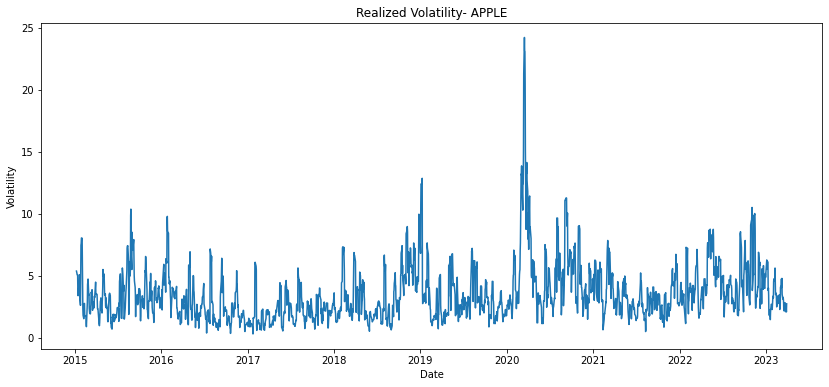

In [12]:
# Plotting the realized volatility
plt.figure(figsize=(14, 6))
plt.plot(df['realized_vol'])
plt.title('Realized Volatility- APPLE')
plt.ylabel('Volatility')
plt.xlabel('Date');

# ARCH Model

In [13]:
# Defining the split and assigning the split data
n = 252
split_date = df['return'].iloc[-n:].index
split_date

DatetimeIndex(['2022-03-29', '2022-03-30', '2022-03-31', '2022-04-01',
               '2022-04-04', '2022-04-05', '2022-04-06', '2022-04-07',
               '2022-04-08', '2022-04-11',
               ...
               '2023-03-16', '2023-03-17', '2023-03-20', '2023-03-21',
               '2023-03-22', '2023-03-23', '2023-03-24', '2023-03-27',
               '2023-03-28', '2023-03-29'],
              dtype='datetime64[ns]', name='Date', length=252, freq=None)

In [14]:
sgm2 = df['return'].var() # Calculate the variance
K = df['return'].kurtosis() # Calculate the kurtosis
alpha = (-3.0 * sgm2 + np.sqrt(9.0 * sgm2 ** 2 - 12.0 *
            (3.0 * sgm2 - K) * K)) / (6 * K) # Identifying the initial value
omega = (1 - alpha) * sgm2 
initial_parameters = [alpha, omega]
omega, alpha

(nan, nan)

In [15]:
def arch_likelihood(initial_parameters, returns):
    omega = abs(initial_parameters[0]) 
    alpha = abs(initial_parameters[1]) # Using abs values of initial values
    T = len(returns)
    logliks = 0
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(returns) # Initial value of volatility
    for t in range(1, T):
        sigma2[t] = omega + alpha * (returns[t - 1]) ** 2 # Iterationg variance
    logliks = np.sum(0.5 * (np.log(sigma2)+returns ** 2 / sigma2)) 
    return logliks # Minimized log-likelihood function

In [16]:
logliks = arch_likelihood(initial_parameters, df['return'])
logliks

0.6312239635306398

In [17]:
# Built-in function for ARCH modelling
arch = arch_model(df['return'], mean='zero', vol='ARCH', p=1).fit(disp='off')
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4170.15
Distribution:                  Normal   AIC:                           8344.30
Method:            Maximum Likelihood   BIC:                           8355.57
                                        No. Observations:                 2069
Date:                Fri, Mar 31 2023   Df Residuals:                     2069
Time:                        19:47:04   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          2.7346      0.193     14.182  1.188e-45 [  2.357,  3.11

In [18]:
# Tuning the ARCH model with respect to lag parameter
bic_arch = []
for p in range(1, 22): 
    arch = arch_model(df['return'], mean='zero', vol='ARCH', p=p)\
             .fit(disp='off')
    bic_arch.append(arch.bic)
    if arch.bic == np.min(bic_arch): 
        best_param = p
best_param # Extracting the best number of lags

8

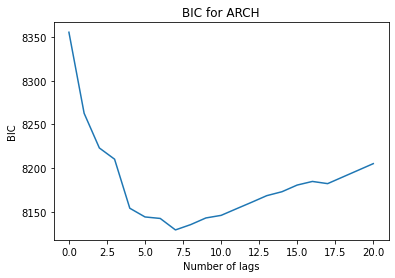

In [19]:
# Plotting the Bayesian Information Criterion for the ARCH model w.r.t. lag
plt.plot(bic_arch)
plt.title('BIC for ARCH')
plt.ylabel('BIC')
plt.xlabel('Number of lags');

In [20]:
arch = arch_model(df['return'], mean='zero', vol='ARCH', p=best_param)\
                 .fit(disp='off') # Building the model based on the best lag
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4030.24
Distribution:                  Normal   AIC:                           8078.48
Method:            Maximum Likelihood   BIC:                           8129.19
                                        No. Observations:                 2069
Date:                Fri, Mar 31 2023   Df Residuals:                     2069
Time:                        19:47:07   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          1.1198      0.180      6.232  4.597e-10 

In [21]:
forecast = arch.forecast(start=split_date[0]) # Forecasting based on ARCH
forecast_arch = forecast
rmse_arch = np.sqrt(mse(df.loc[split_date,'realized_vol']/100,
                     np.sqrt(forecast_arch\
                     .variance.iloc[-len(split_date):]/100
                     ))) # Testing the accuracy of the ARCH model
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model is 0.1626


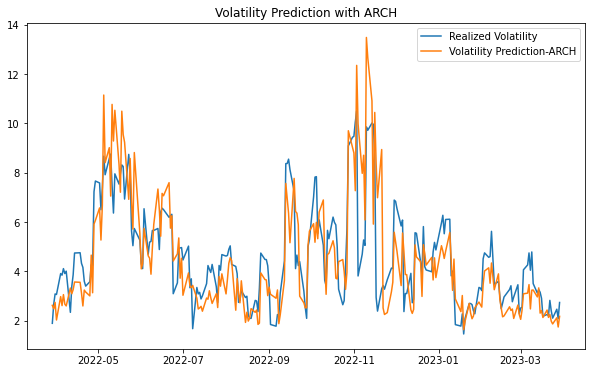

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(df.loc[split_date,'realized_vol'], label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):],
      label='Volatility Prediction-ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()

In [23]:
forecast_arch.variance.iloc[-len(split_date):]

,h.1
Date,
2022-03-29,2.625167
2022-03-30,2.486806
2022-03-31,2.744383
2022-04-01,2.032239
2022-04-04,2.979732
...,...
2023-03-23,1.983029
2023-03-24,1.871835
2023-03-27,2.122666


In [24]:
df.loc[split_date,'realized_vol']*sqrt(5)

Date
2022-03-29    4.242728
2022-03-30    5.958375
2022-03-31    6.904069
2022-04-01    6.858107
2022-04-04    8.751020
                ...   
2023-03-23    5.375000
2023-03-24    4.713274
2023-03-27    5.522956
2023-03-28    4.663915
2023-03-29    6.131349
Name: realized_vol, Length: 252, dtype: float64